In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.signal import find_peaks, argrelextrema,argrelmax,argrelmin
import scipy.stats as stats
from scipy.stats import genextreme as gev
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps
from xhistogram.xarray import histogram
import rpy2
from rpy2.robjects.packages import importr, data
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects import globalenv
pandas2ri.activate()

extRemes = importr("extRemes")
evgam = importr("evgam")
%load_ext rpy2.ipython

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("cma.mplstyle")

In [4]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

# READ AFI, DJF Temperature and topography FILES

In [5]:
yearb=1980
yeare=2008

files=[f'../AFI/AFI_ERA5_{iyear}_fullUSA_method3.nc' for iyear in range(yearb,yeare+1)]

ds=xr.open_mfdataset(files)
ds=ds.sortby('lat')

return_periods=[2, 5, 10, 25, 50, 100]
Tlon=ds.lon.data
Tlat=ds.lat.data

units='degree-days (°F)'

dsm=xr.open_dataset('../AFI/ERA5_air.2m.DJFclim.nc')
dsm=dsm.drop('season')
dsm=dsm.sortby('lat')
ds=ds.merge({'air':dsm['air']})

dsh=xr.open_dataset('../AFI/ERA5_hgt.sfc.nc')
dsh=dsh.sortby('lat')

/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/2095090559.py:16: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  dsm=dsm.drop('season')


# Reduce domain for testing purpose

In [6]:
lon_min=245;lon_max=255
lat_min=28;lat_max=48

In [7]:
ds=ds.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
dsm=dsm.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
dsh=dsh.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
Tlon=ds.lon.data
Tlat=ds.lat.data

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/3021935927.py:10: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_title('DJF Temp ($\degree$C)',fontsize=14)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/3021935927.py:13: SyntaxWarning: invalid escape sequence '\d'
  ax[2].set_title('mean AFI ($\degree$-days(F))',fontsize=14)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/3021935927.py:23: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=1

[Text(0, 30.0, '30$\\degree$N'),
 Text(0, 32.5, '32$\\degree$N'),
 Text(0, 35.0, '35$\\degree$N'),
 Text(0, 37.5, '38$\\degree$N'),
 Text(0, 40.0, '40$\\degree$N'),
 Text(0, 42.5, '42$\\degree$N'),
 Text(0, 45.0, '45$\\degree$N'),
 Text(0, 47.5, '48$\\degree$N')]

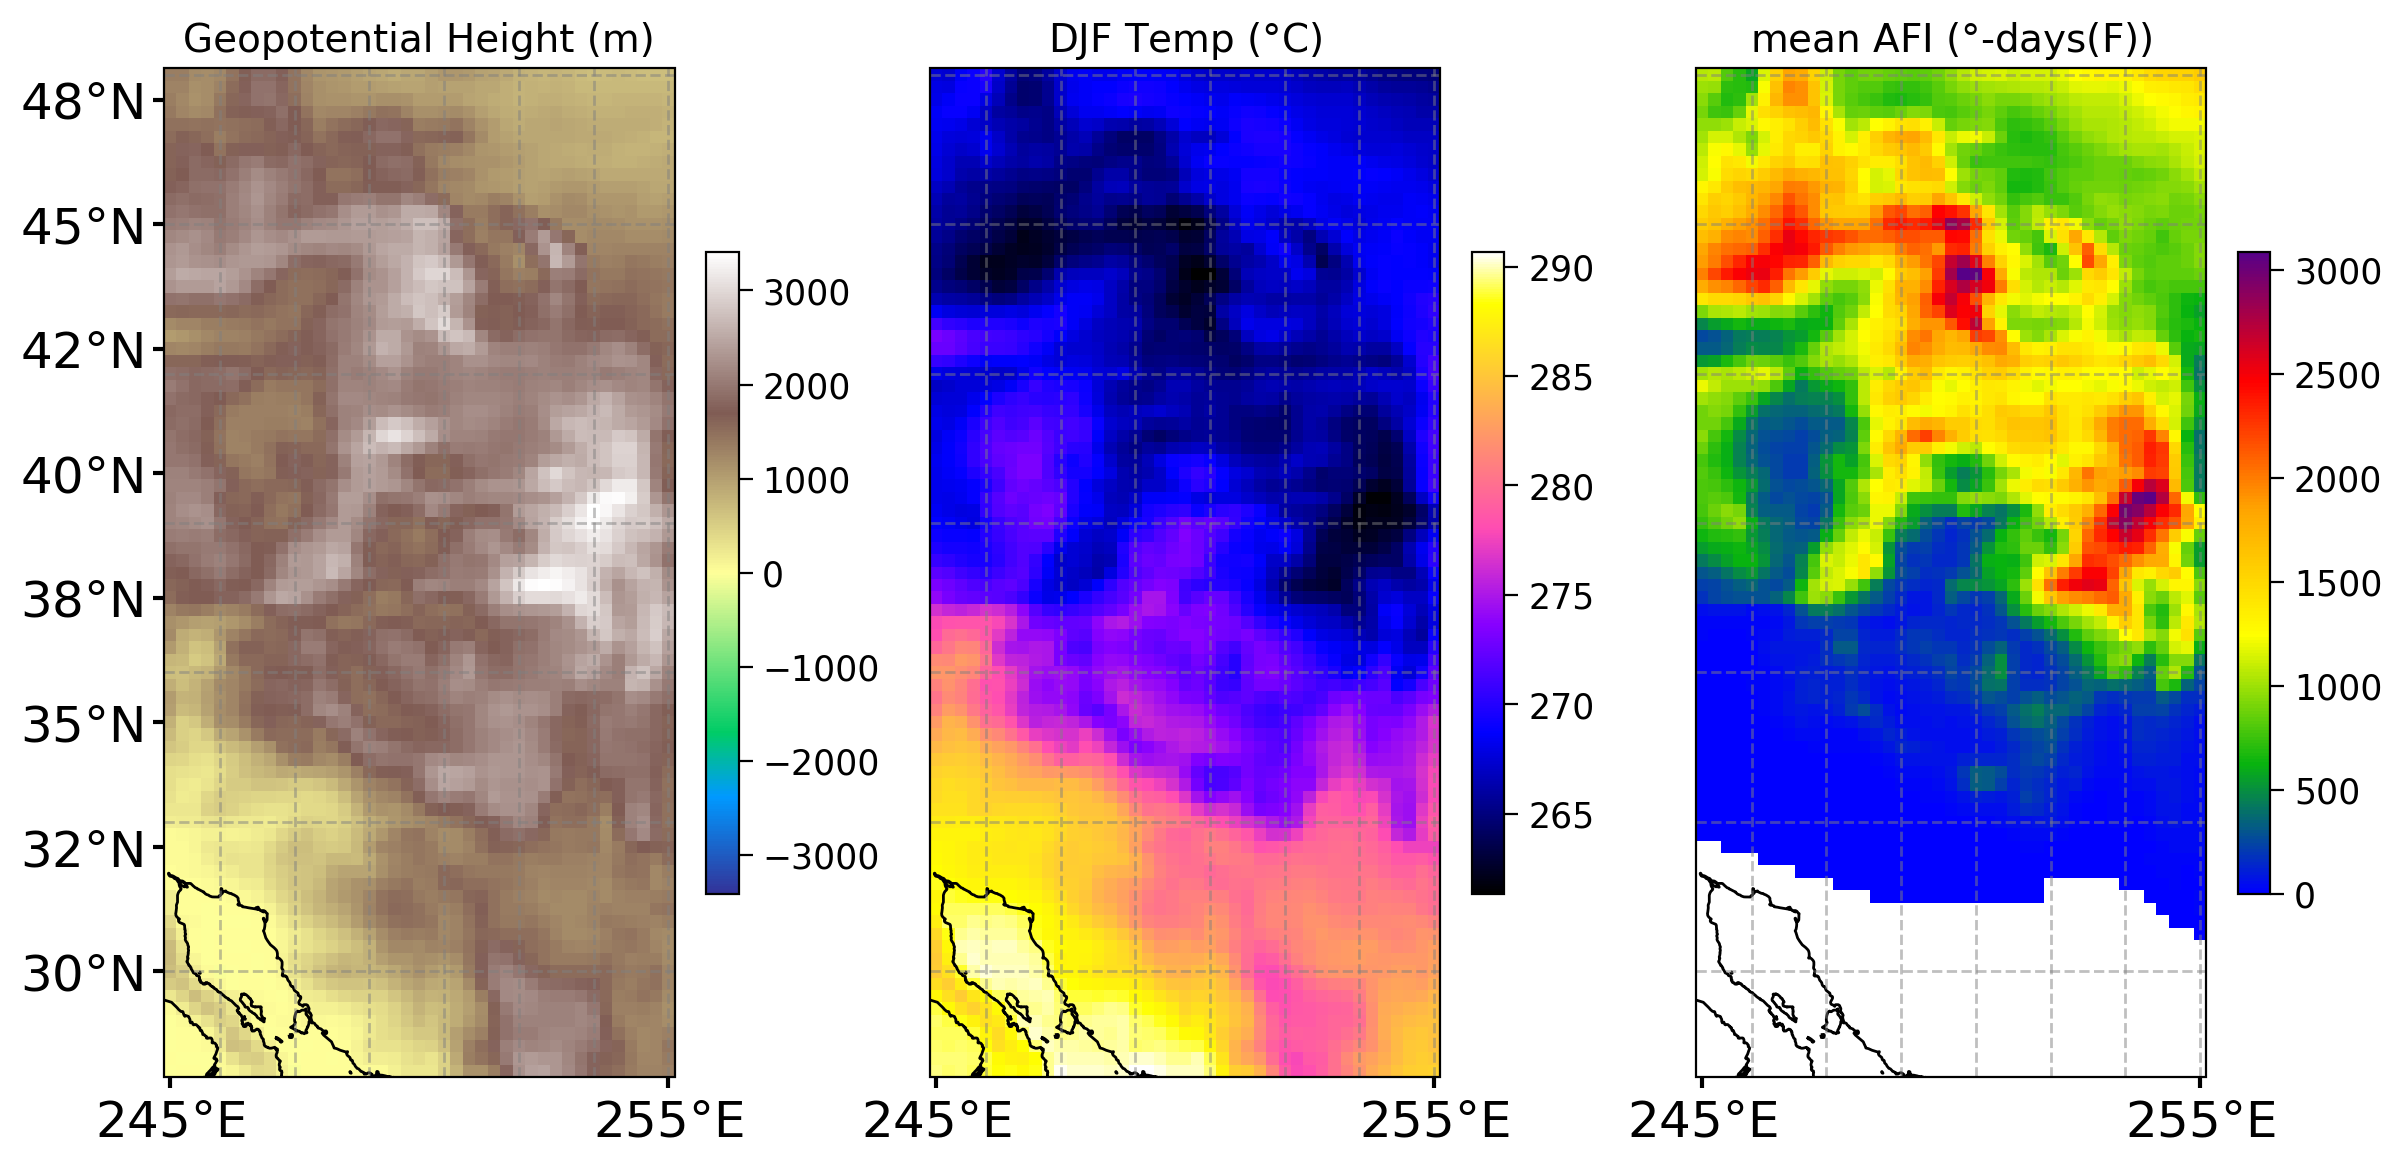

In [8]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(14,8),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9)

dsh['hgt'].plot(ax=ax[0],cmap='terrain',cbar_kwargs={'label':'','shrink':0.55})
ax[0].set_title('Geopotential Height (m)',fontsize=14)

dsm['air'].plot(ax=ax[1],cmap='gnuplot2',cbar_kwargs={'label':'','shrink':0.55})
ax[1].set_title('DJF Temp ($\degree$C)',fontsize=14)

ds['AFI'].mean('time').plot(ax=ax[2],cmap=cmap,cbar_kwargs={'label':'','shrink':0.55})
ax[2].set_title('mean AFI ($\degree$-days(F))',fontsize=14)

for ix in range(0,len(ax)):
  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].coastlines()
  #ax[ix].add_feature(state_borders,zorder=10,linewidth=0.25,edgecolor='k')
  gr=ax[ix].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--',draw_labels=False)
  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  ax[ix].set_xticks(ax[ix].get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
ax[0].set_yticks(ax[0].get_yticks()[1:-1],crs=ccrs.PlateCarree())
ax[0].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[0].get_yticks()],size=18)

# Define EVGAM parameters for smoothness 

In [9]:
# parameters for smoothness 
%R fmla_gev <- list(AFI ~ s(air, bs = "cr"), ~ s(lon, lat) , ~ s(lon, lat))

o{'None': AFI ~ s(air, bs = "cr")
, 'None': ~s(lon, lat)
, 'None': ~s(lon, lat)
, }

# evgam fit_gev and rl100
# through box 20x20pts ~6


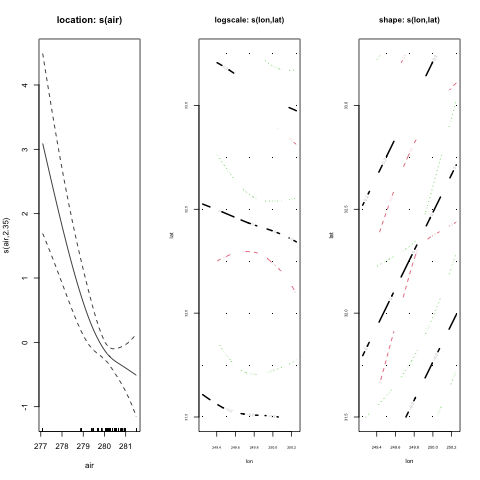

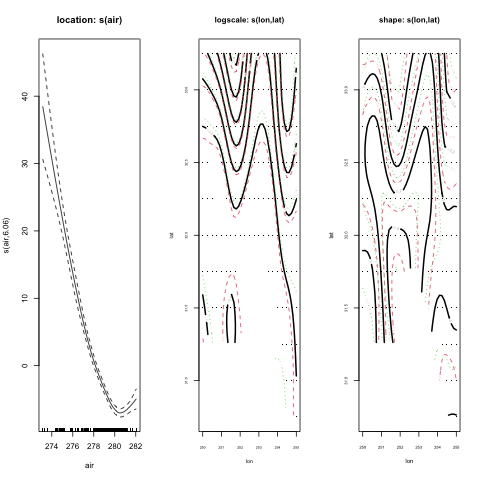

R[write to console]: Final Hessian of negative penalized log-likelihood not numerically positive definite.



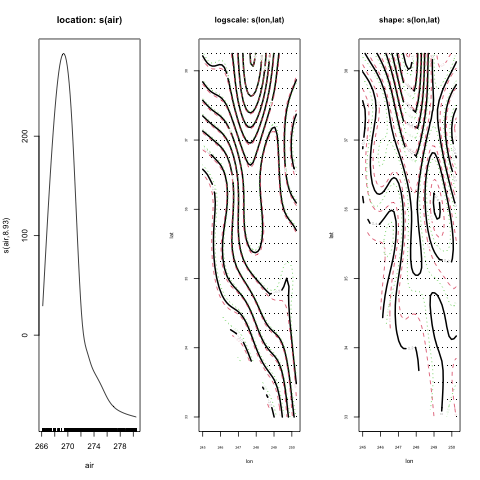

R[write to console]: Final Hessian of negative penalized log-likelihood not numerically positive definite.



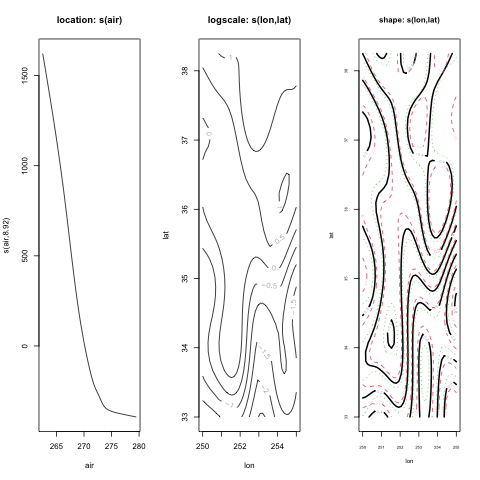

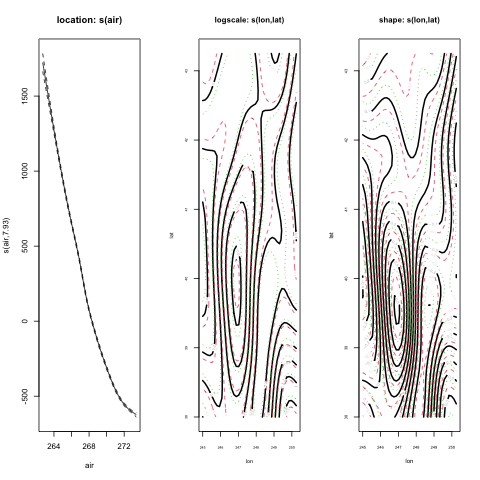

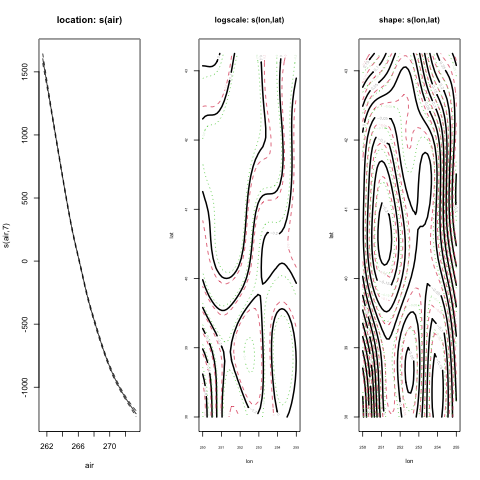

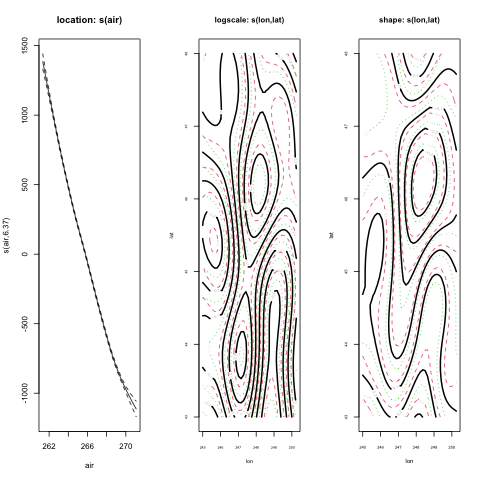

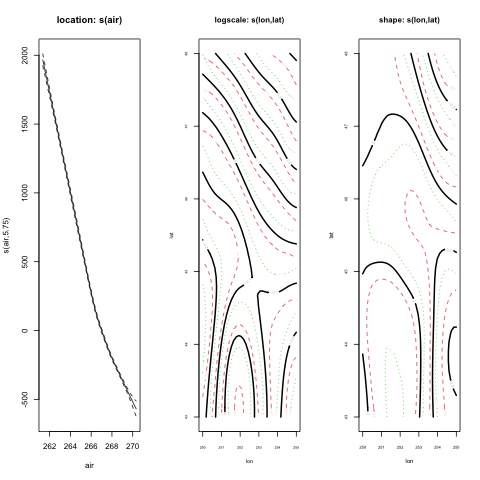

In [10]:
ib=[0,20,0,20,0,20,0,20]
jb=[0,0,20,20,40,40,60,60]

Rlocation=xr.zeros_like(dsm['air'])*np.nan
Rshape=xr.zeros_like(dsm['air'])*np.nan
Rscale=xr.zeros_like(dsm['air'])*np.nan
Rrl100=xr.zeros_like(dsm['air'])*np.nan

for ii in range(0,len(ib)): # looop through boxes
  # Extract values for boxes
  dsij=ds.isel(lon=slice(ib[ii],ib[ii]+22),lat=slice(jb[ii],jb[ii]+22)).load()
  dsmij=dsm.isel(lon=slice(ib[ii],ib[ii]+22),lat=slice(jb[ii],jb[ii]+22))
  df = dsij.to_dataframe()

  # Remove zeros if any and any timeseries with less than 15 data (as in Bilotta et al.)
  df = df[df['AFI'] > 0.]
  df=df.groupby(['lon', 'lat']).filter(lambda x: len(x) > 15)
  df = df.reset_index()

  # Convert xarray to pandas DataFrame to R data.frame
  # You can now work with 'r_df' in R
  dfm=df[['lon','lat','air']]
  dfo=dsmij[['lon','lat']].to_dataframe().reset_index()

  r_df = ro.conversion.py2rpy(df)
  r_dfm=ro.conversion.py2rpy(dfm)
  globalenv['r_df'] = r_df
  globalenv['r_dfm'] = r_dfm

  # EVGAM model fitting  
  %R m_gev <- evgam(fmla_gev, r_df, family = "gev")
  %R plot(m_gev)
  %R gev_pred <- predict(m_gev, r_dfm, type = "response")
  %R gev_rl100 <- predict(m_gev, r_dfm, prob = 0.99)
  %R -o gev_pred,gev_rl100,r_dfm  # get R data to python

  # Convert R data.frame to xarray
  gev_pred['lon']=r_dfm['lon']
  gev_pred['lat']=r_dfm['lat']
  merged = pd.concat([gev_pred, dfo[~dfo.lon.isin(gev_pred.lon)],dfo[~dfo.lat.isin(gev_pred.lat)]], ignore_index=True)
  merged.drop_duplicates(subset=['lon','lat'],keep='first', inplace=True)
  dsgev_pred=merged.set_index(['lat','lon']).to_xarray()
  #
  gev_rl100['lon']=r_dfm['lon']
  gev_rl100['lat']=r_dfm['lat']
  merged = pd.concat([gev_rl100, dfo[~dfo.lon.isin(gev_rl100.lon)],dfo[~dfo.lat.isin(gev_rl100.lat)]], ignore_index=True)
  merged.drop_duplicates(subset=['lon','lat'],keep='first', inplace=True)
  dsgev_rl100=merged.set_index(['lat','lon']).to_xarray()
  Rlon = dsgev_pred['lon'][1:21]
  Rlat = dsgev_pred['lat'][1:21]

  # Save boxes data 
  # and remove of lon_edges
  Rlocation.loc[{'lon':Rlon,'lat':Rlat}]=dsgev_pred['location'][1:21,1:21]
  Rscale.loc[{'lon':Rlon,'lat':Rlat}]=dsgev_pred['scale'][1:21,1:21]
  Rshape.loc[{'lon':Rlon,'lat':Rlat}]=dsgev_pred['shape'][1:21,1:21]
  Rrl100.loc[{'lon':Rlon,'lat':Rlat}]=dsgev_rl100['q:0.99'][1:21,1:21]

<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\d'
<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/4062984085.py:27: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/4062984085.py:29: SyntaxWarning: invalid escape sequence '\d'
  ax[0].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[0].get_yticks()],size=18)


[Text(0, 30.0, '30$\\degree$N'),
 Text(0, 32.5, '32$\\degree$N'),
 Text(0, 35.0, '35$\\degree$N'),
 Text(0, 37.5, '38$\\degree$N'),
 Text(0, 40.0, '40$\\degree$N'),
 Text(0, 42.5, '42$\\degree$N'),
 Text(0, 45.0, '45$\\degree$N'),
 Text(0, 47.5, '48$\\degree$N')]

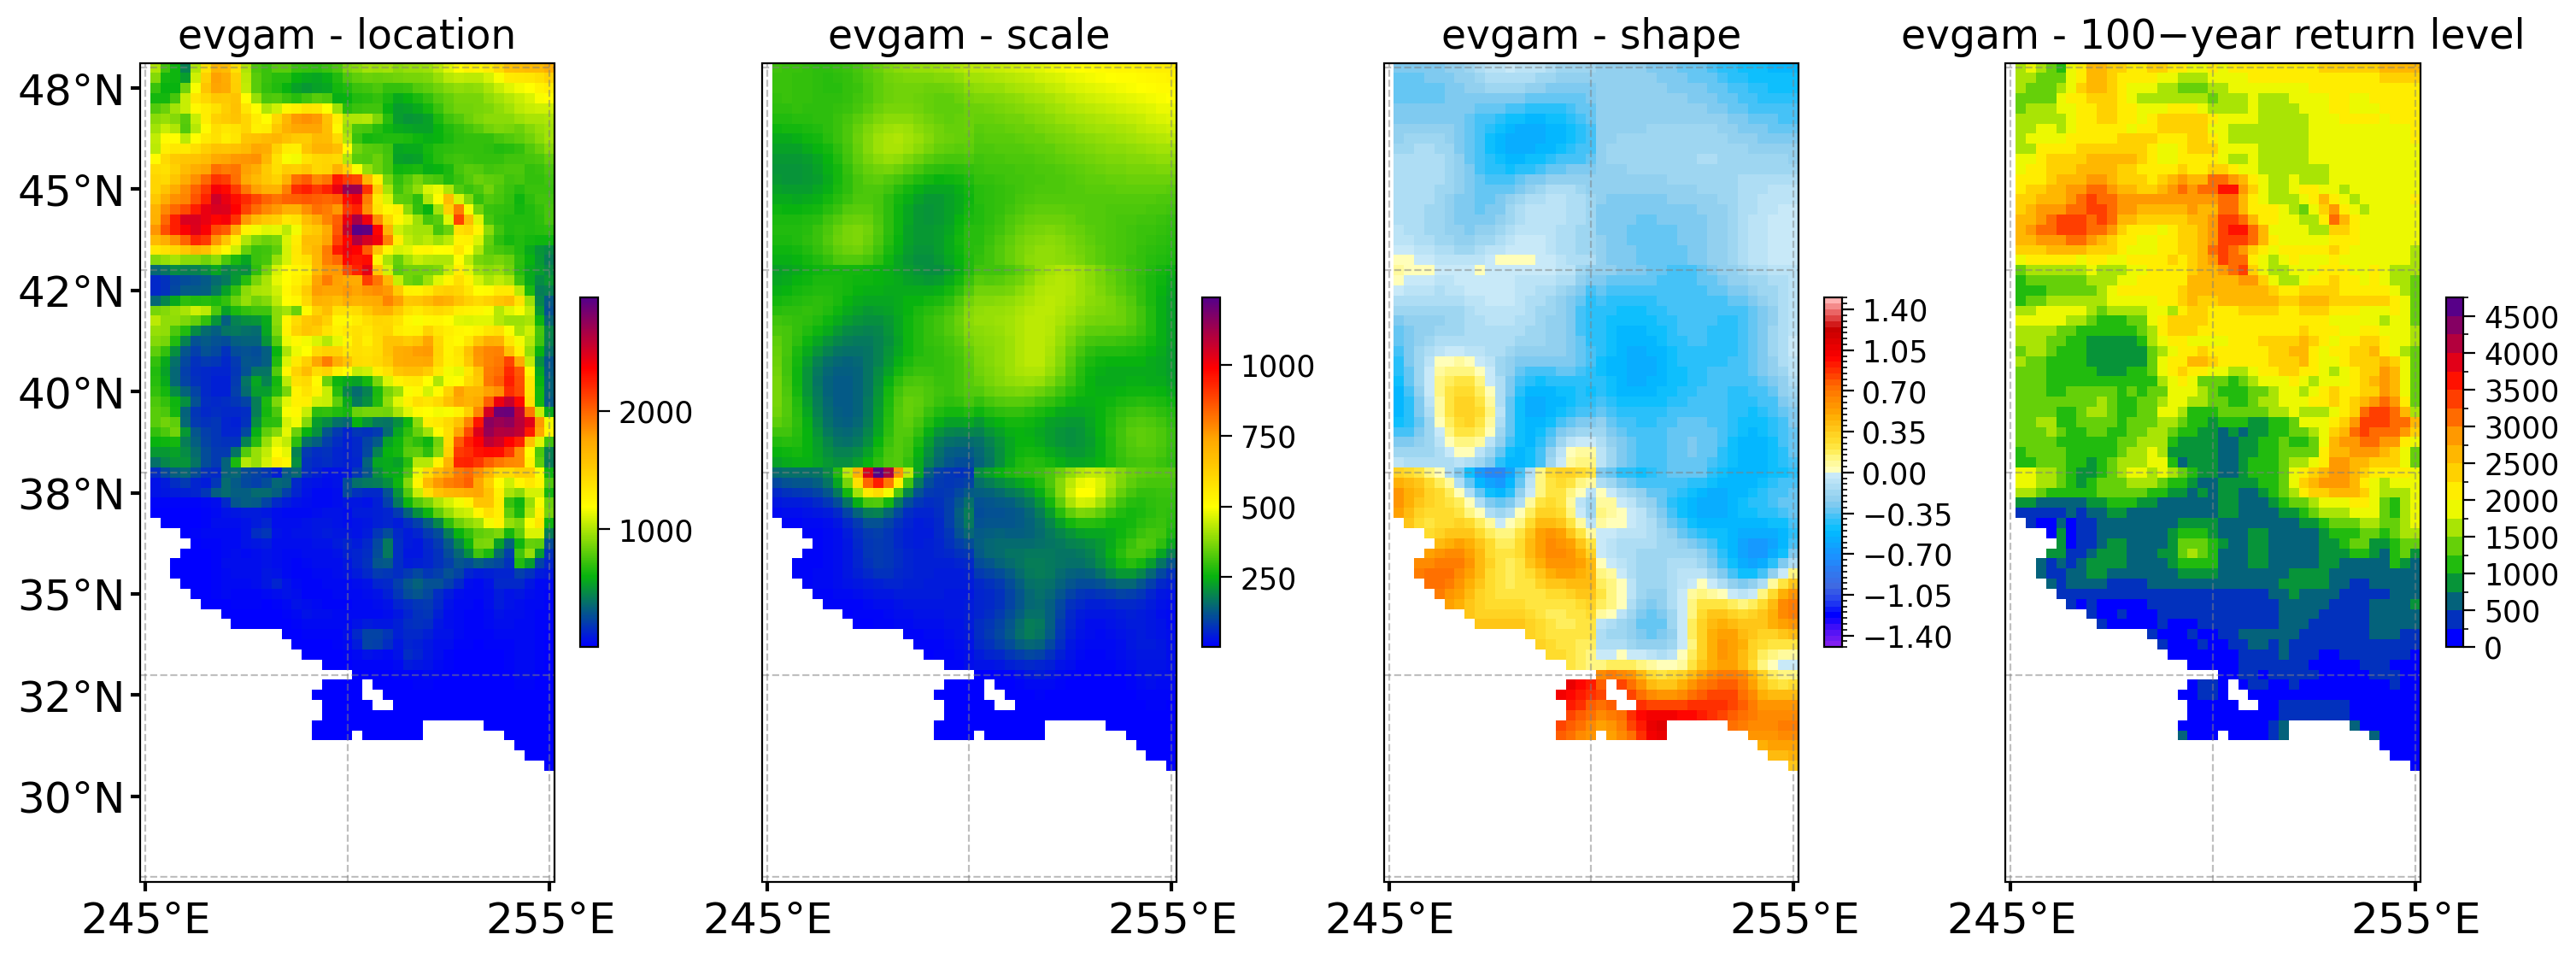

In [18]:

proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(18,8),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9,wspace=0.2)

Rlocation.plot(ax=ax[0],cmap=cmaps.BlGrYeOrReVi200,cbar_kwargs={'label':'','shrink':0.35})
ax[0].set_title('evgam - location',fontsize=17)

Rscale.plot(ax=ax[1],cmap=cmaps.BlGrYeOrReVi200,cbar_kwargs={'label':'','shrink':0.35})
ax[1].set_title('evgam - scale',fontsize=17)

Rshape.plot(ax=ax[2],cmap=cmaps.ncl_default,levels=np.arange(-1.5,1.55,0.05),cbar_kwargs={'label':'','shrink':0.35})
ax[2].set_title('evgam - shape',fontsize=17)

Rrl100.plot(ax=ax[3],cmap=cmaps.BlGrYeOrReVi200,levels=np.arange(0,5000,250),cbar_kwargs={'label':'','shrink':0.35})
ax[3].set_title('evgam - 100−year return level',fontsize=17)
for ix in range(0,len(ax)):
  grd = ax[ix].gridlines(
    draw_labels=False, 
    xlocs=[Tlon[0]-360,Tlon[20]-360,Tlon[40]-360], 
    ylocs=[Tlat[0], Tlat[20], Tlat[40],Tlat[60],Tlat[80]], 
    color='gray', alpha=0.5, linestyle='--')

  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  ax[ix].set_xticks(ax[ix].get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
ax[0].set_yticks(ax[0].get_yticks()[1:-1],crs=ccrs.PlateCarree())
ax[0].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[0].get_yticks()],size=18)

boxes in grey

# Compute GEV parameters with scipy.stats.

In [12]:
return_period = [2, 5, 10, 25, 50, 100]
rp = return_period[-1]
Slocation = xr.zeros_like(dsm['air'])*np.nan
Sshape = xr.zeros_like(dsm['air'])*np.nan
Sscale = xr.zeros_like(dsm['air'])*np.nan
Srl100 = xr.zeros_like(dsm['air'])*np.nan
for j in range(0,len(ds['lat'])):
  for i in range(0,len(ds['lon'])):
     data = ds['AFI'].isel(lon=i,lat=j).load()
     afi_values = data.values
     # Remove zeros if any (as in Bilotta et al.)
     nonzero_afis = afi_values[afi_values > 0]
     if len(nonzero_afis)>15:
       shape, loc, scale = gev.fit(data.where(data>0,drop=True), loc=nonzero_afis.mean(), scale=nonzero_afis.std(),method="MLE")
       Sshape[j,i] = shape
       Slocation[j,i] = loc
       Sscale[j,i] = scale
       p = 1 - 1/rp
       # Get the AFI value for this return period
       Srl100[j,i] = stats.genextreme.ppf(p, shape, loc, scale)

# Difference between the 2 methods. 

<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:35: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/1677926647.py:33: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/1677926647.py:35: SyntaxWarning: invalid escape sequence '\d'
  ax[0].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[0].get_yticks()],size=18)


[Text(0, 30.0, '30$\\degree$N'),
 Text(0, 32.5, '32$\\degree$N'),
 Text(0, 35.0, '35$\\degree$N'),
 Text(0, 37.5, '38$\\degree$N'),
 Text(0, 40.0, '40$\\degree$N'),
 Text(0, 42.5, '42$\\degree$N'),
 Text(0, 45.0, '45$\\degree$N'),
 Text(0, 47.5, '48$\\degree$N')]

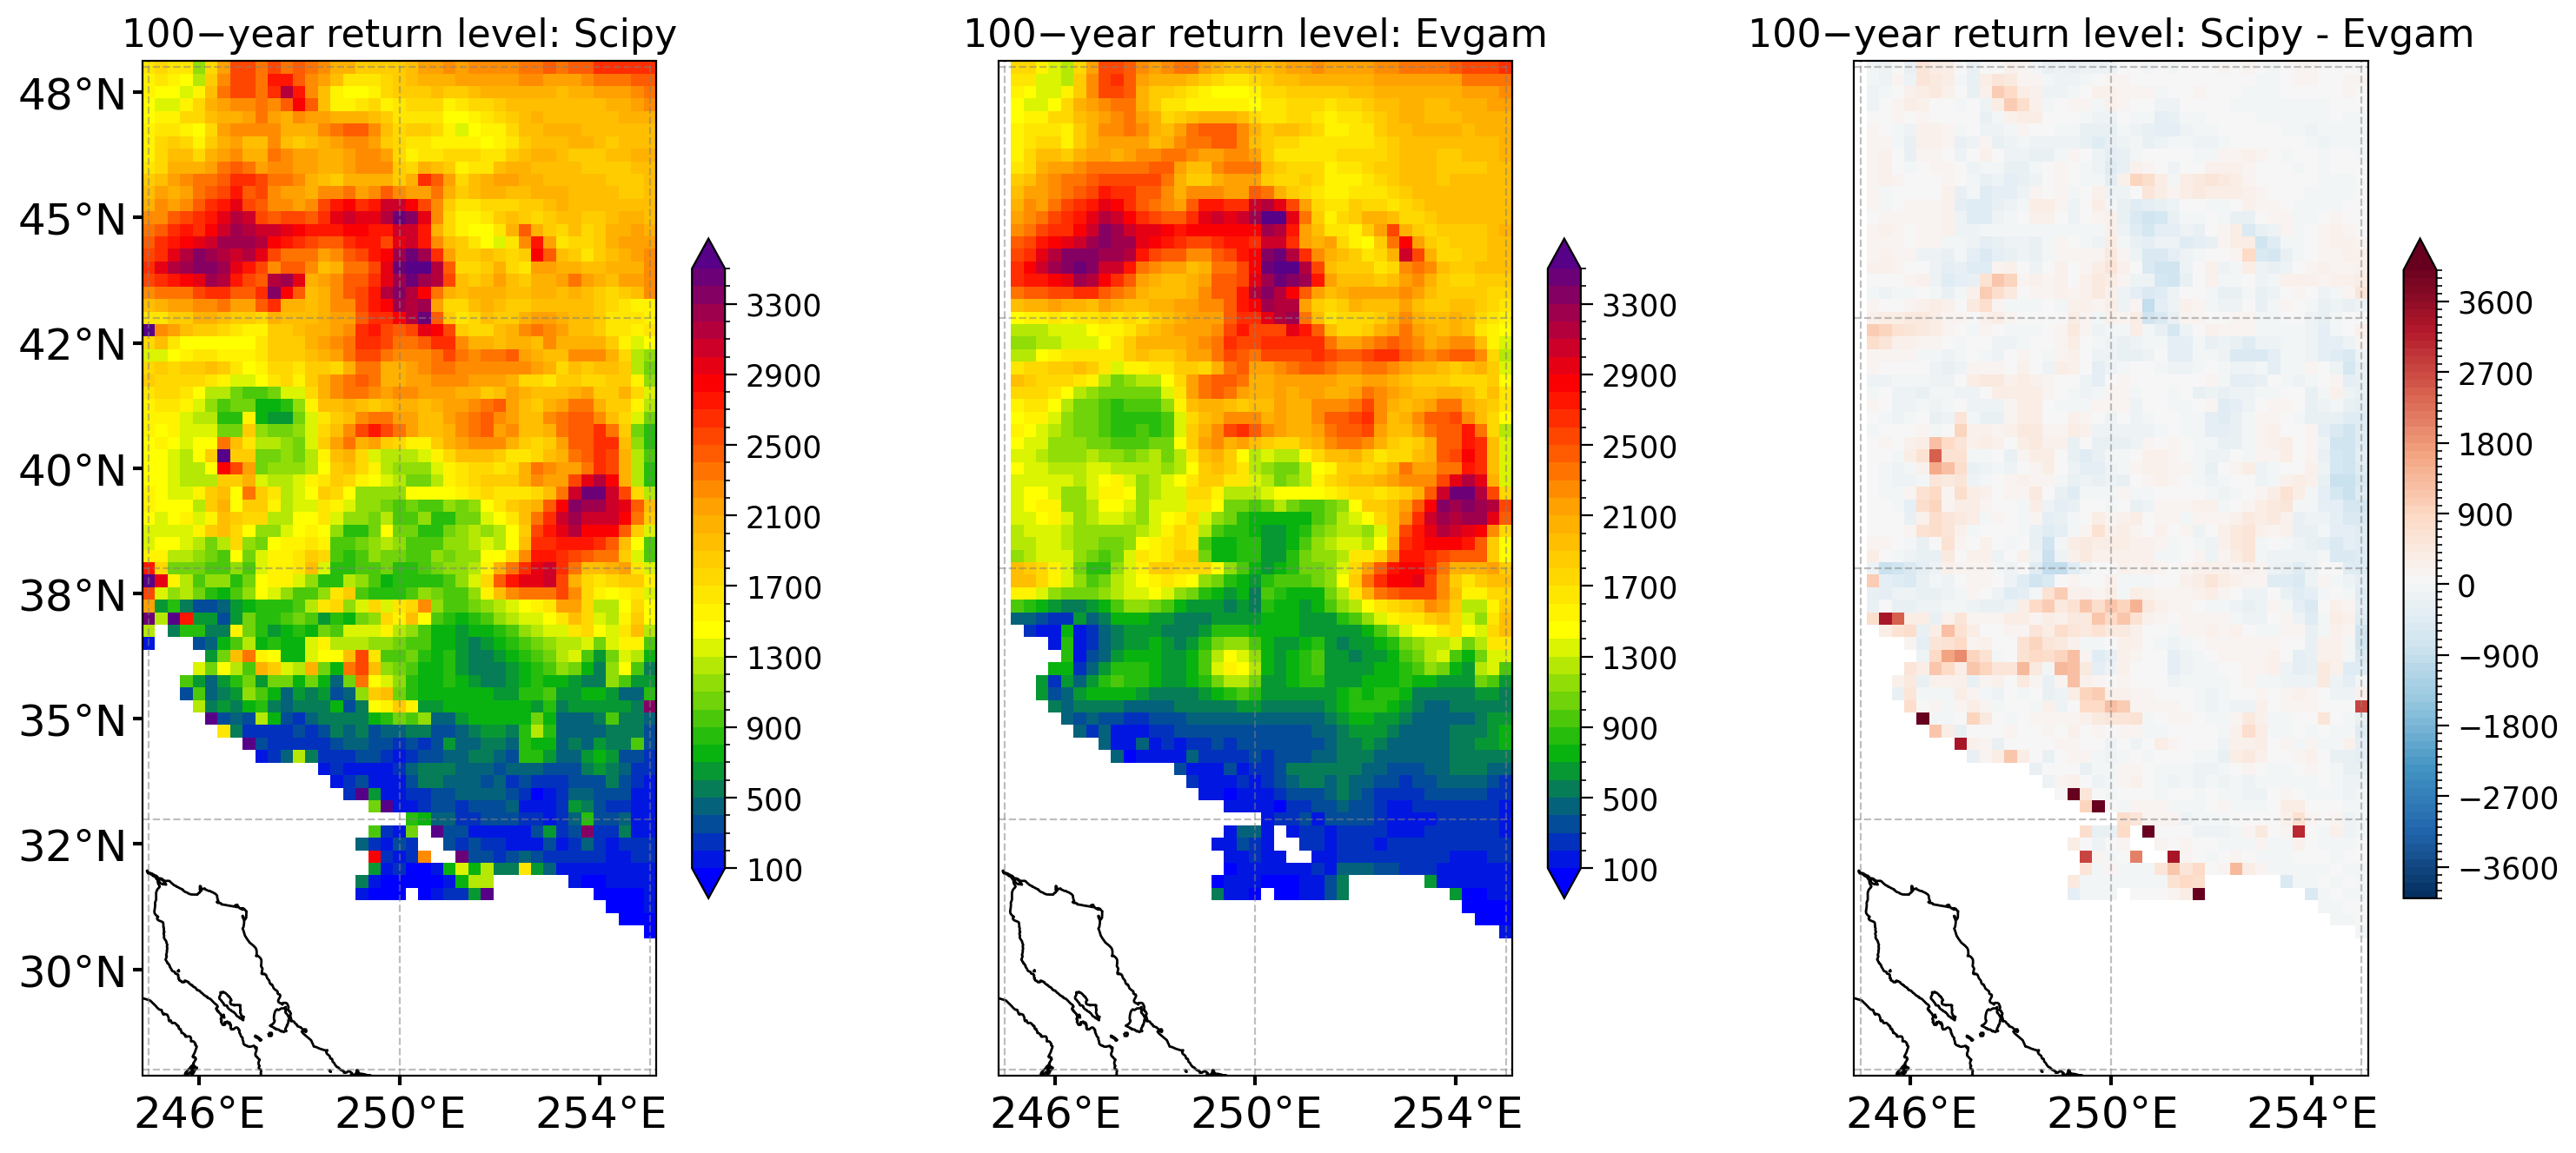

In [13]:
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(18,8),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9,hspace=0.15)
#
data=Srl100
data=data#.isel(lon=slice(1,nbi-1))
data.plot(ax=ax[0],cmap=cmap,levels=np.arange(100,3600,100),cbar_kwargs={'label':'','shrink':0.65})
ax[0].set_title('100−year return level: Scipy',fontsize=16)
#
data=Rrl100
data=data#.isel(lon=slice(1,nbi-1))
data.plot(ax=ax[1],cmap=cmap,levels=np.arange(100,3600,100),cbar_kwargs={'label':'','shrink':0.65})
#ax[1].contour(dsij['lon'].isel(lon=slice(1,19)),dsij['lat'],dsij['AFI'].mean('time').isel(lon=slice(1,19)),color='k')
ax[1].set_title('100−year return level: Evgam',fontsize=16)
#
data=(Srl100-Rrl100)
data=data#.isel(lon=slice(1,nbi-1))
data.plot(ax=ax[2],levels=np.arange(-4000,4100,100),cbar_kwargs={'label':'','shrink':0.65})
#ax[2].contour(data['lon'],data['lat'],dsmij['air'].isel(lon=slice(1,19)),cmap='terrain')
ax[2].set_title('100−year return level: Scipy - Evgam',fontsize=16)
for ix in range(0,len(ax)):
  grd = ax[ix].gridlines(
    draw_labels=False, 
    xlocs=[Tlon[0]-360,Tlon[20]-360,Tlon[40]-360], 
    ylocs=[Tlat[0], Tlat[20], Tlat[40],Tlat[60],Tlat[80]], 
    color='gray', alpha=0.5, linestyle='--')
  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].coastlines()

  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  ax[ix].set_xticks(ax[ix].get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
ax[0].set_yticks(ax[0].get_yticks()[1:-1],crs=ccrs.PlateCarree())
ax[0].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[0].get_yticks()],size=18)

The 100-year return level is expressed in degree-days (F).

<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:44: SyntaxWarning: invalid escape sequence '\d'
<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:44: SyntaxWarning: invalid escape sequence '\d'
<>:46: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/4164735923.py:42: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/4164735923.py:44: SyntaxWarning: invalid escape sequence '\d'
  ax[0].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[0].get_yticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/4164735923.py:46: SyntaxWarning: invalid escape sequence '\d'
  ax[4].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[4].get_yticks()],size=18)


[Text(0, 30.0, '30$\\degree$N'),
 Text(0, 32.5, '32$\\degree$N'),
 Text(0, 35.0, '35$\\degree$N'),
 Text(0, 37.5, '38$\\degree$N'),
 Text(0, 40.0, '40$\\degree$N'),
 Text(0, 42.5, '42$\\degree$N'),
 Text(0, 45.0, '45$\\degree$N'),
 Text(0, 47.5, '48$\\degree$N')]

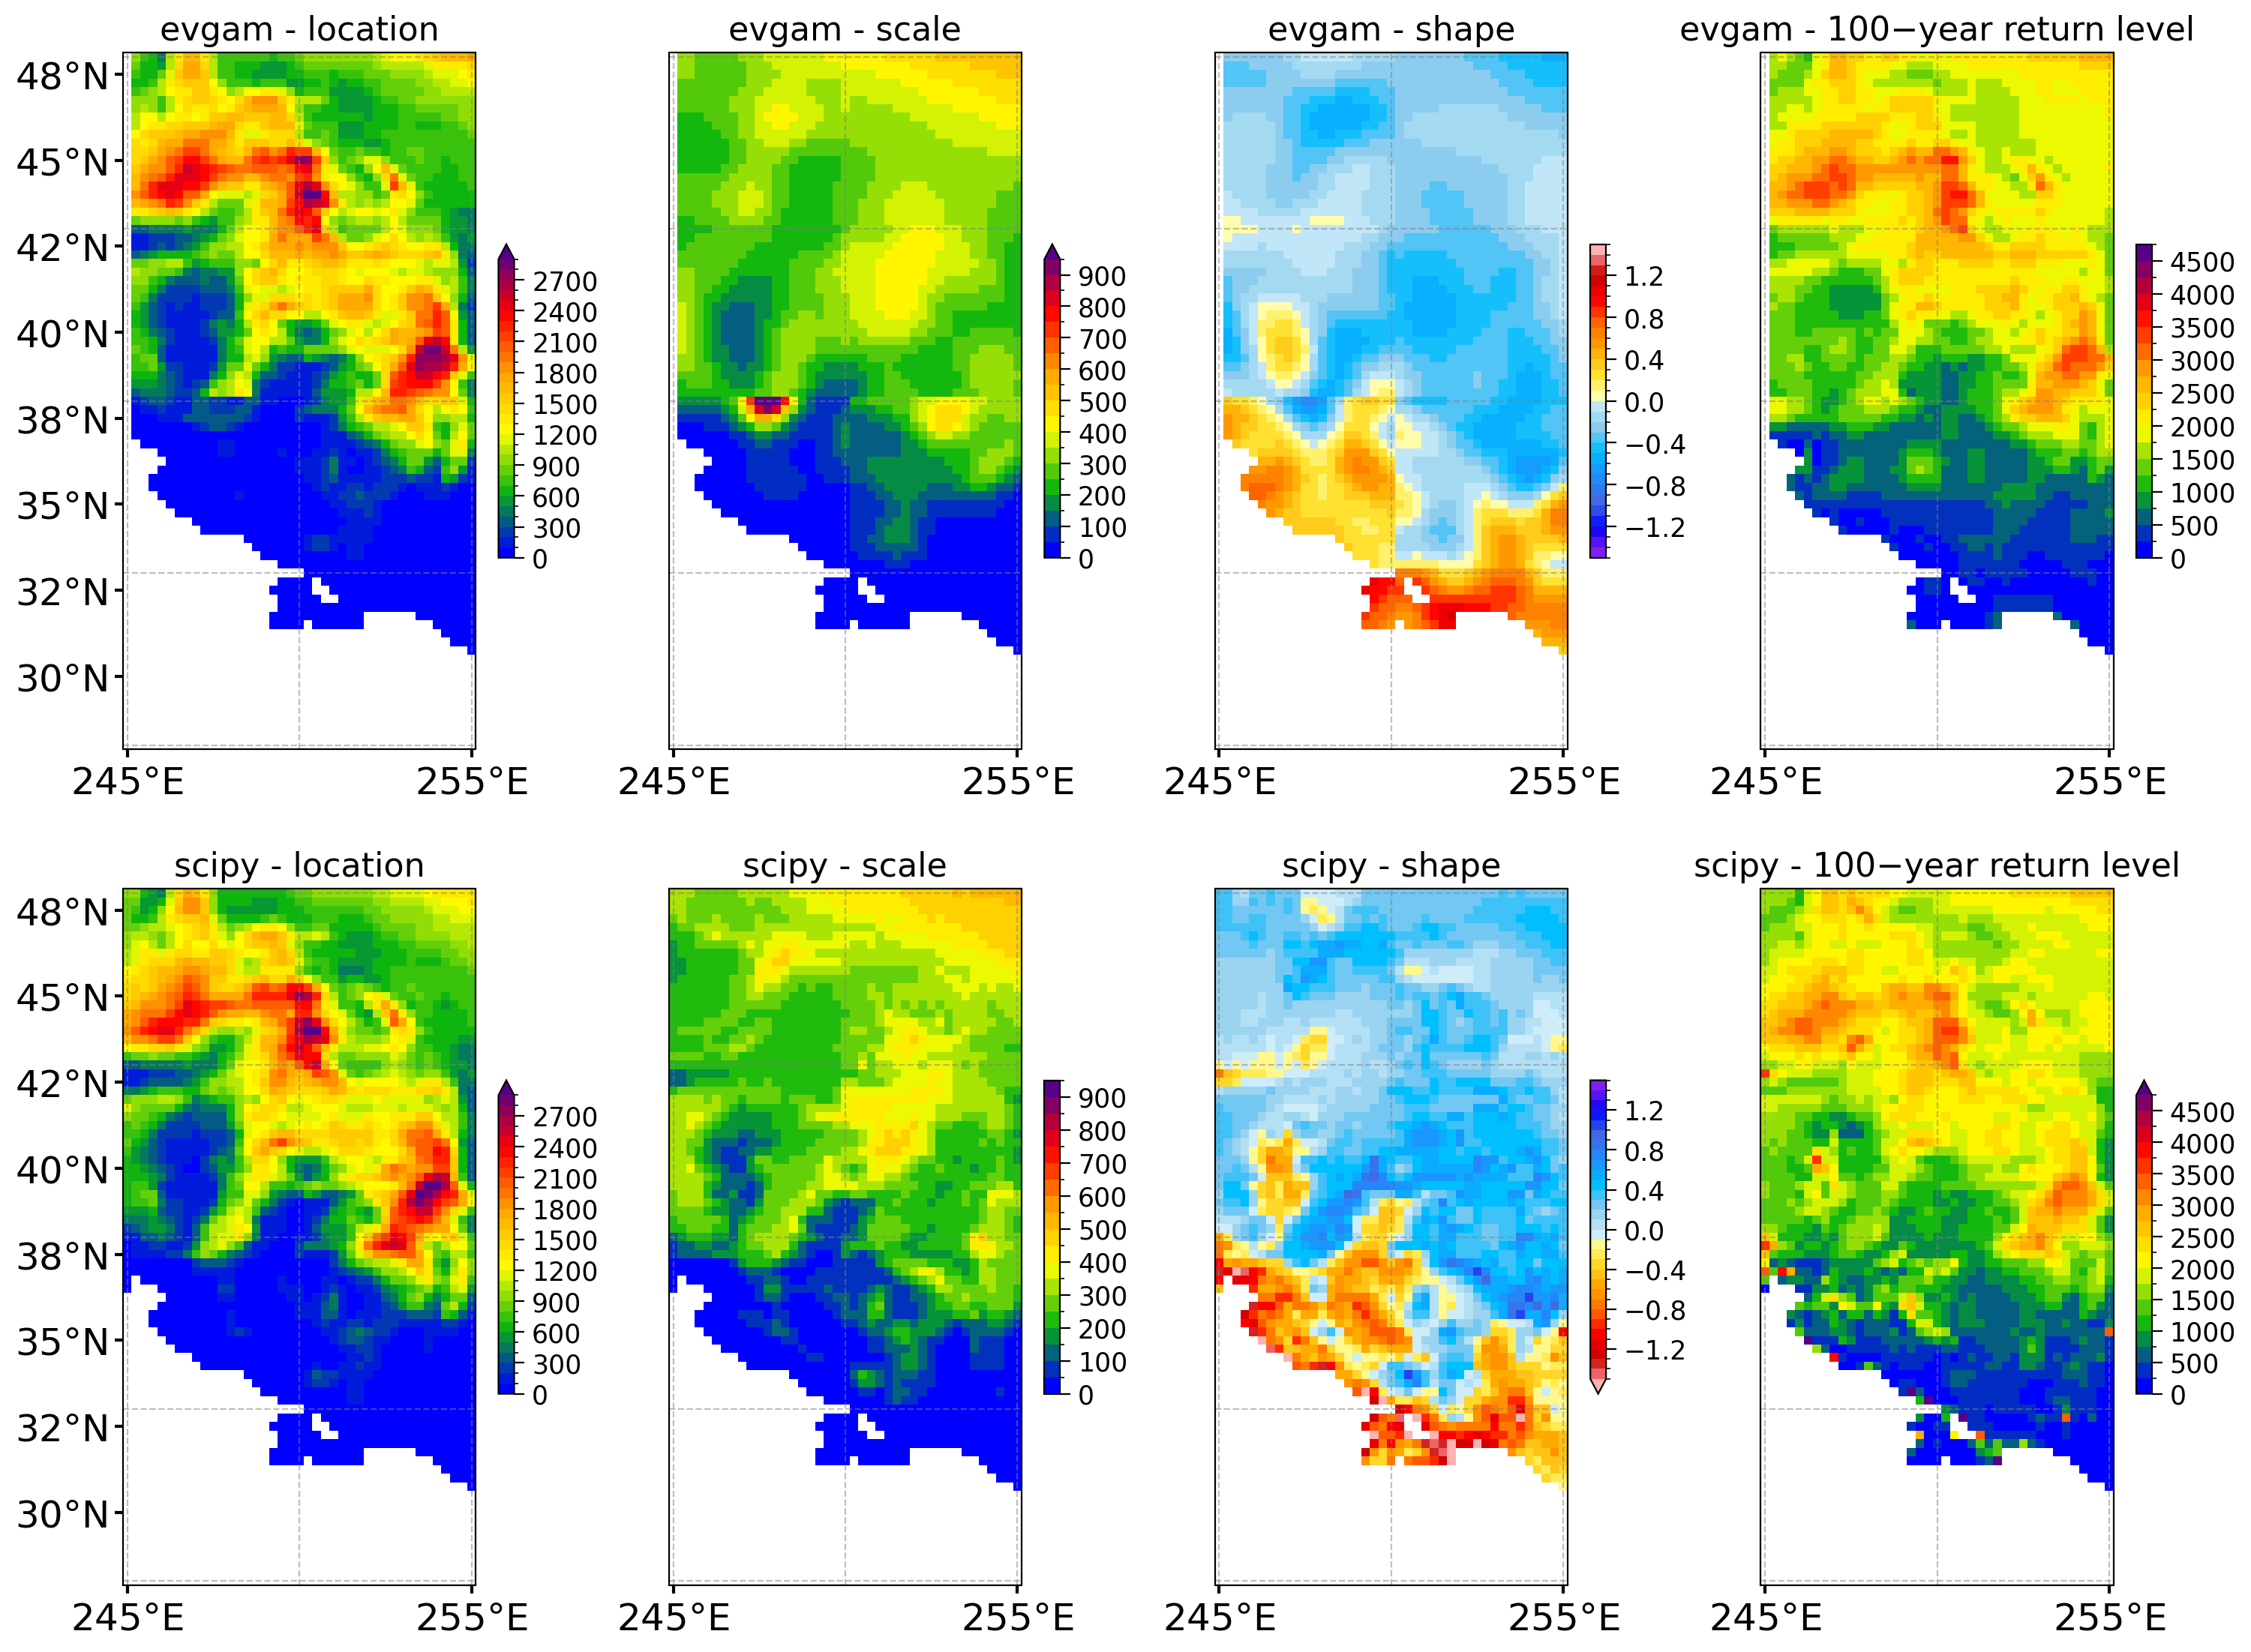

In [19]:

proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=2,ncols=4,figsize=(18,14),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9,wspace=0.2)
ax=ax.flatten()
Rlocation.plot(ax=ax[0],cmap=cmaps.BlGrYeOrReVi200,levels=np.arange(0,3000,100),cbar_kwargs={'label':'','shrink':0.45})
ax[0].set_title('evgam - location',fontsize=16)

Rscale.plot(ax=ax[1],cmap=cmaps.BlGrYeOrReVi200,levels=np.arange(0,1000,50),cbar_kwargs={'label':'','shrink':0.45})
ax[1].set_title('evgam - scale',fontsize=16)

Rshape.plot(ax=ax[2],cmap=cmaps.ncl_default,levels=np.arange(-1.5,1.6,0.1),\
  cbar_kwargs={'label':'','shrink':0.45})
ax[2].set_title('evgam - shape',fontsize=16)

Rrl100.plot(ax=ax[3],cmap=cmaps.BlGrYeOrReVi200,levels=np.arange(0,5000,250),cbar_kwargs={'label':'','shrink':0.45})
ax[3].set_title('evgam - 100−year return level',fontsize=16)

Slocation.plot(ax=ax[4],cmap=cmaps.BlGrYeOrReVi200,levels=np.arange(0,3000,100),cbar_kwargs={'label':'','shrink':0.45})
ax[4].set_title('scipy - location',fontsize=16)

Sscale.plot(ax=ax[5],cmap=cmaps.BlGrYeOrReVi200,levels=np.arange(0,1000,50),cbar_kwargs={'label':'','shrink':0.45})
ax[5].set_title('scipy - scale',fontsize=16)

Sshape.plot(ax=ax[6],cmap=cmaps.ncl_default_r,levels=np.arange(-1.5,1.6,0.1),\
  cbar_kwargs={'label':'','shrink':0.45})
ax[6].set_title('scipy - shape',fontsize=16)

Srl100.plot(ax=ax[7],cmap=cmaps.BlGrYeOrReVi200,levels=np.arange(0,5000,250),cbar_kwargs={'label':'','shrink':0.45})
ax[7].set_title('scipy - 100−year return level',fontsize=16)

for ix in range(0,len(ax)):
  grd = ax[ix].gridlines(
    draw_labels=False, 
    xlocs=[Tlon[0]-360,Tlon[20]-360,Tlon[40]-360], 
    ylocs=[Tlat[0], Tlat[20], Tlat[40],Tlat[60],Tlat[80]], 
    color='gray', alpha=0.5, linestyle='--')

  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  ax[ix].set_xticks(ax[ix].get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
ax[0].set_yticks(ax[0].get_yticks()[1:-1],crs=ccrs.PlateCarree())
ax[0].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[0].get_yticks()],size=18)
ax[4].set_yticks(ax[4].get_yticks()[1:-1],crs=ccrs.PlateCarree())
ax[4].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[4].get_yticks()],size=18)

Due to inverse sign between the R-shape and scipy-shape parameters the colorbar is inverse for the scipy - shape plot.

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/4216095126.py:10: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_title('DJF Temp ($\degree$C)',fontsize=14)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/4216095126.py:13: SyntaxWarning: invalid escape sequence '\d'
  ax[2].set_title('mean AFI ($\degree$-days(F))',fontsize=14)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_47159/4216095126.py:26: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=1

[Text(0, 30.0, '30$\\degree$N'),
 Text(0, 32.5, '32$\\degree$N'),
 Text(0, 35.0, '35$\\degree$N'),
 Text(0, 37.5, '38$\\degree$N'),
 Text(0, 40.0, '40$\\degree$N'),
 Text(0, 42.5, '42$\\degree$N'),
 Text(0, 45.0, '45$\\degree$N'),
 Text(0, 47.5, '48$\\degree$N')]

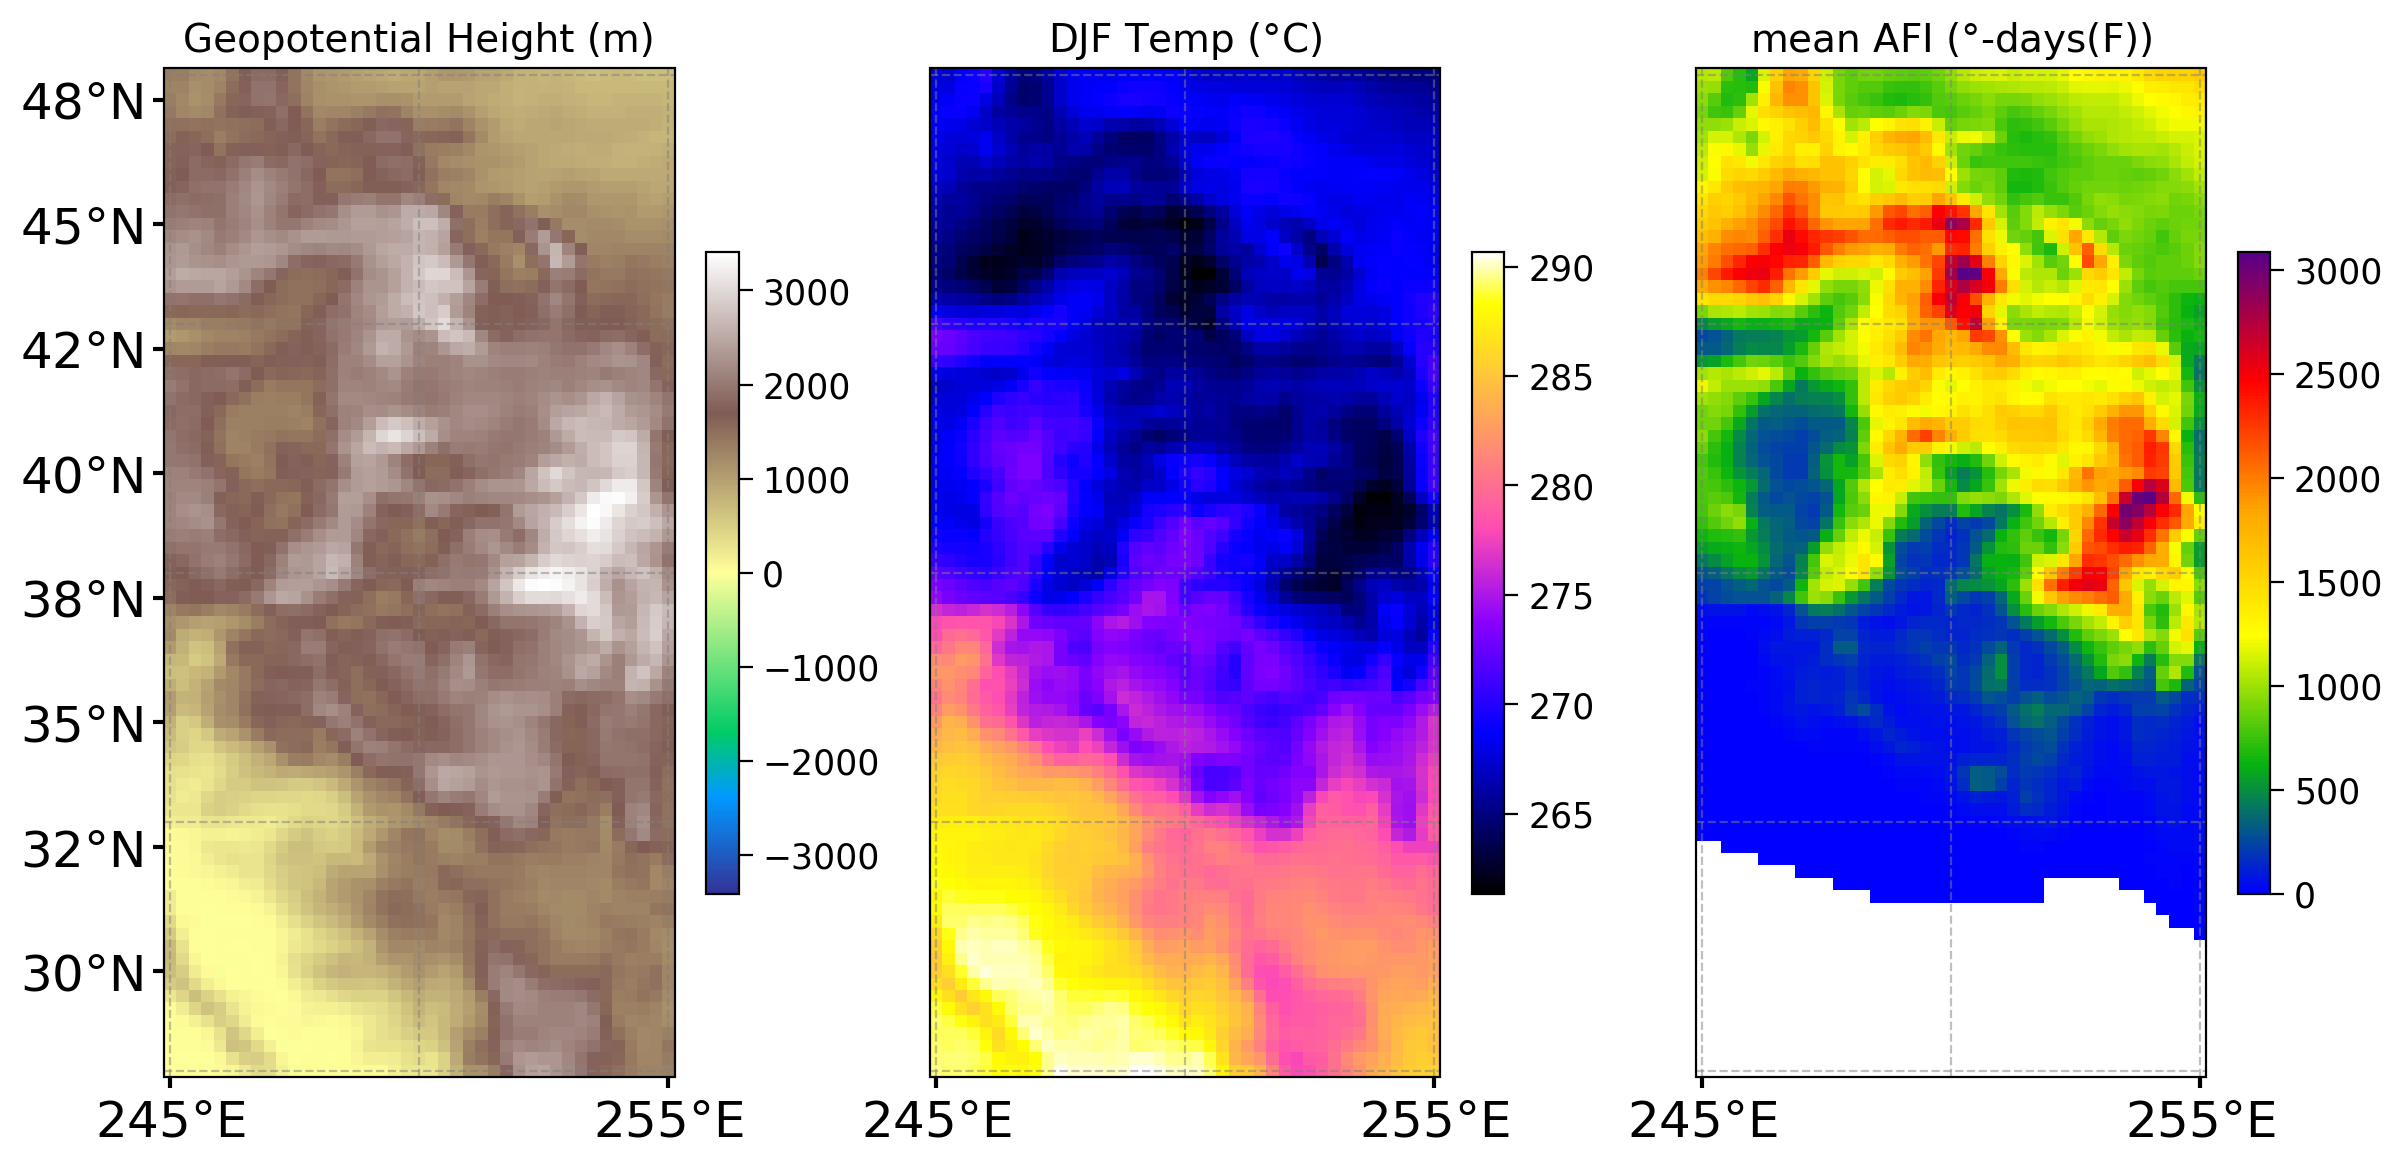

In [15]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(14,8),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9)

dsh['hgt'].plot(ax=ax[0],cmap='terrain',cbar_kwargs={'label':'','shrink':0.55})
ax[0].set_title('Geopotential Height (m)',fontsize=14)

dsm['air'].plot(ax=ax[1],cmap='gnuplot2',cbar_kwargs={'label':'','shrink':0.55})
ax[1].set_title('DJF Temp ($\degree$C)',fontsize=14)

ds['AFI'].mean('time').plot(ax=ax[2],cmap=cmap,cbar_kwargs={'label':'','shrink':0.55})
ax[2].set_title('mean AFI ($\degree$-days(F))',fontsize=14)

for ix in range(0,len(ax)):

  grd = ax[ix].gridlines(
    draw_labels=False, 
    xlocs=[Tlon[0]-360,Tlon[20]-360,Tlon[40]-360], 
    ylocs=[Tlat[0], Tlat[20], Tlat[40],Tlat[60],Tlat[80]], 
    color='gray', alpha=0.5, linestyle='--')
  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  ax[ix].set_xticks(ax[ix].get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
ax[0].set_yticks(ax[0].get_yticks()[1:-1],crs=ccrs.PlateCarree())
ax[0].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[0].get_yticks()],size=18)